In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = blstm_lstm_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         120800    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           50200     
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           357   

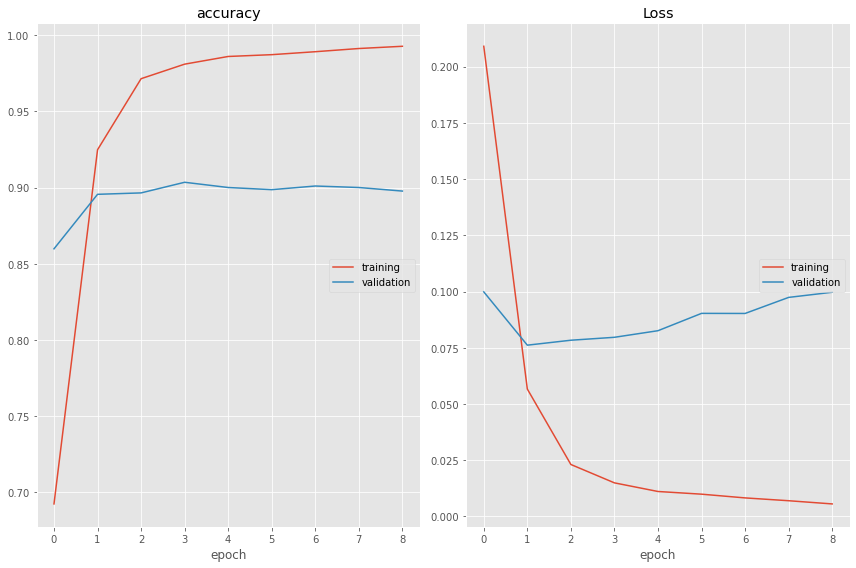

accuracy
	training         	 (min:    0.692, max:    0.993, cur:    0.993)
	validation       	 (min:    0.860, max:    0.903, cur:    0.898)
Loss
	training         	 (min:    0.006, max:    0.209, cur:    0.006)
	validation       	 (min:    0.076, max:    0.100, cur:    0.100)

Epoch 9: val_loss did not improve from 0.07616
56/56 [==============================] - 2s 34ms/step - loss: 0.0947 - accuracy: 0.8990
[0.0947413221001625, 0.8989846110343933]


In [8]:
root_path = 'model/'
model_name = 'blstm_lstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [9]:
from keras.models import load_model

mdl = load_model('model/blstm_lstm_model.h5')

In [10]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [11]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.9116    0.9486    0.9297     22309
          JV     0.8585    0.8148    0.8361      4914
          EN     0.9406    0.8044    0.8672      5020
   MIX-ID-EN     0.9193    0.7492    0.8256       973
   MIX-ID-JV     0.6897    0.5714    0.6250       280
   MIX-JV-EN     0.8791    0.6823    0.7683       277
           O     0.8593    0.8900    0.8744     10151

    accuracy                         0.8951     43924
   macro avg     0.8654    0.7801    0.8180     43924
weighted avg     0.8954    0.8951    0.8940     43924



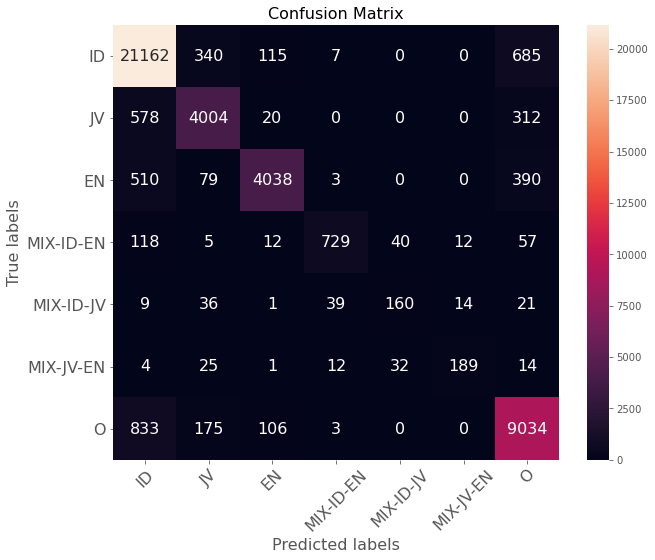

In [12]:
performance_report(true_flat, pred_flat)

In [13]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	ID
rek                           JV        	JV
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-EN
fillet                        EN        	ID
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana 

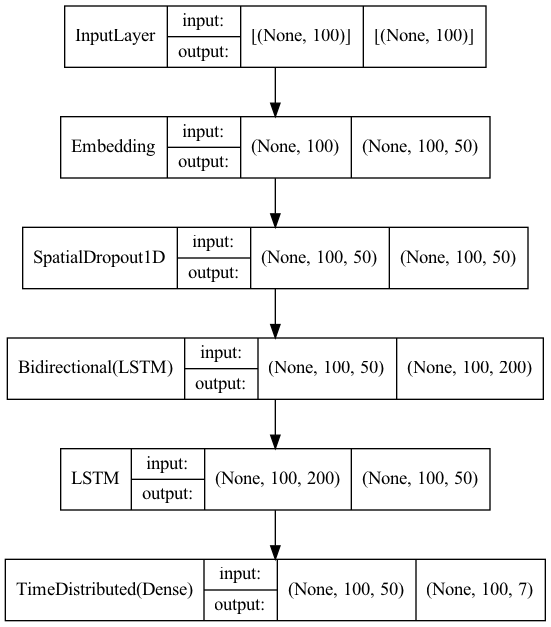

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(mdl, to_file='model_plot/tr_blstm_lstm.png', show_shapes=True, show_layer_names=False)